In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import multiview_dataset
from multiview_dataset import MultiViewDataset, MultiViewDatasetSampler

import pandas as pd
import numpy as np
import torchvision
import imageio
import torch

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler
from random import shuffle
from rhodin.python.utils import datasets as rhodin_utils_datasets
from rhodin.python.utils import io as rhodin_utils_io
from tqdm import tqdm

In [10]:
config_dict_module = multiview_dataset.rhodin_utils_io.loadModule("configs/config_train.py")
config_dict = config_dict_module.config_dict

dataset = MultiViewDataset(
             data_folder=config_dict['data_dir_path'],
             input_types=['img_crop'], label_types=['img_crop'])

batch_sampler = MultiViewDatasetSampler(
             data_folder=config_dict['data_dir_path'],
             use_subject_batches=1, use_view_batches=2,
             batch_size=8,
             randomize=True)

trainloader = DataLoader(dataset, batch_sampler=batch_sampler,
                         num_workers=0, pin_memory=False,
                         collate_fn=multiview_dataset.rhodin_utils_datasets.default_collate_with_string)

data_iterator = iter(trainloader)

print('Number of frames in dataset: ', len(dataset))

100%|██████████| 235/235 [00:00<00:00, 18232.06it/s]

Loading .csv label file to memory
Loading .csv label file to memory
Establishing sequence association. Available labels: ['Unnamed: 0', 'interval', 'interval_ind', 'view', 'subject', 'pain', 'frame']
DictDataset: Done initializing, listed 235 viewsets (235 frames) and 6 sequences
Randomizing dataset (MultiViewDatasetSampler.__iter__)
Number of frames in dataset:  940


In [11]:
input_dict, label_dict = next(data_iterator)

In [12]:

def tensor_to_npimg(torch_array):
    return np.swapaxes(np.swapaxes(torch_array.numpy(), 0, 2), 0, 1)

def denormalize(np_array):
    #std then mean, from config file
    return np_array * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))

# extract image
def tensor_to_img(output_tensor):
    output_img = tensor_to_npimg(output_tensor)
    output_img = denormalize(output_img)
    output_img = np.clip(output_img, 0, 1)
    return output_img

In [13]:
input_dict['img_crop'].shape

torch.Size([8, 3, 128, 128])

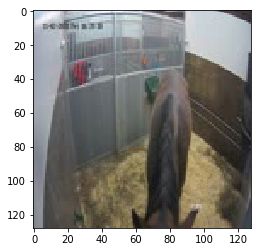

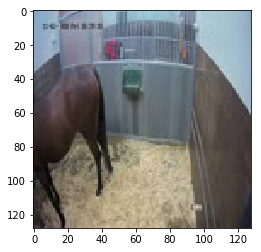

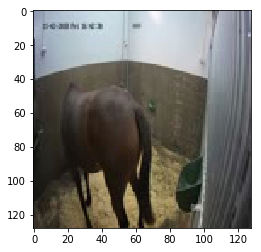

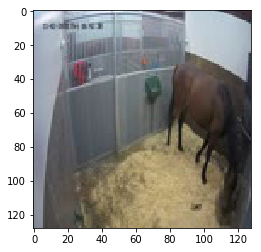

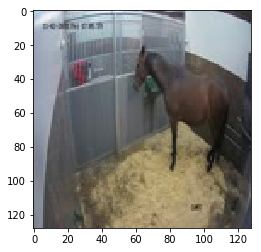

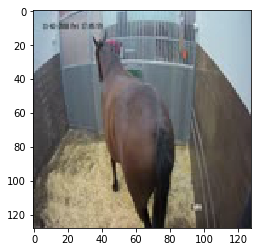

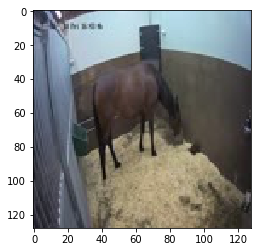

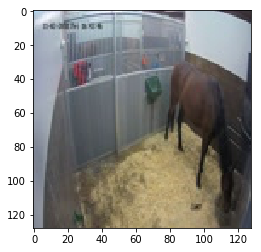

In [17]:
for i in range(8):
    img_tensor = input_dict['img_crop'][i,:]
    plt.imshow(tensor_to_img(img_tensor))
    plt.show()

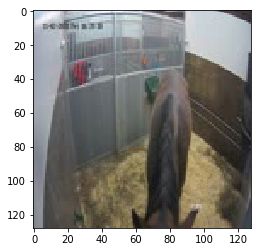

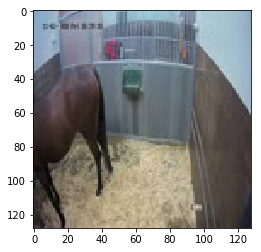

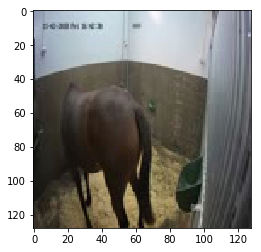

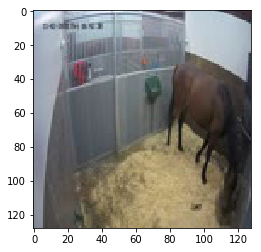

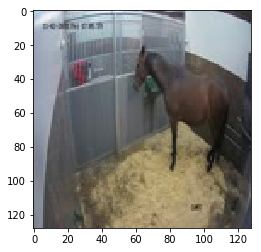

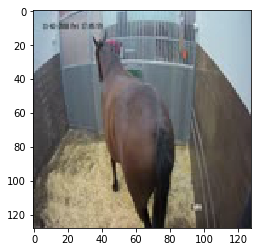

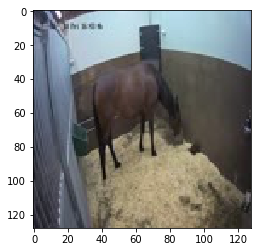

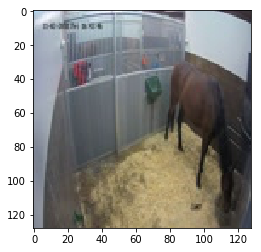

In [18]:
for i in range(8):
    img_tensor = label_dict['img_crop'][i,:]
    plt.imshow(tensor_to_img(img_tensor))
    plt.show()

## Frames debugging

In [2]:
config_dict_module = multiview_dataset.rhodin_utils_io.loadModule("configs/config_train.py")
config_dict = config_dict_module.config_dict

dataset = MultiViewDataset(
             data_folder=config_dict['data_dir_path'],
             input_types=['img_crop'], label_types=['img_crop'],
             subjects=config_dict['train_subjects'])

batch_sampler = MultiViewDatasetSampler(
             subjects=config_dict['train_subjects'],
             data_folder=config_dict['data_dir_path'],
             use_subject_batches=1, use_view_batches=2,
             batch_size=8,
             randomize=True)

trainloader = DataLoader(dataset, batch_sampler=batch_sampler,
                         num_workers=0, pin_memory=False,
                         collate_fn=multiview_dataset.rhodin_utils_datasets.default_collate_with_string)

data_iterator = iter(trainloader)

print('Number of frames in dataset: ', len(dataset))

Iterating over frame indices per subject (.csv files)
Iterating over frame indices per subject (.csv files)


 33%|███▎      | 37476/115200 [00:00<00:00, 374752.32it/s]

Establishing sequence association. Available labels: ['Unnamed: 0', 'interval', 'interval_ind', 'view', 'subject', 'pain', 'frame']


  7%|▋         | 1994/28800 [00:00<00:01, 19929.23it/s]

DictDataset: Done initializing, listed 28800 viewsets (28800 frames) and 5 sequences
Randomizing dataset (MultiViewDatasetSampler.__iter__)


100%|██████████| 28800/28800 [00:20<00:00, 1376.79it/s]

Number of frames in dataset:  115200


In [4]:
import os.path
from tqdm import tqdm

subjects = ['aslan', 'brava', 'herrera', 'inkasso', 'julia', 'kastanjett', 'naughty_but_nice', 'sir_holger']

def get_image_name(subject, interval_ind, interval, view, frame):                                                                                                                           
    frame_id = '_'.join([subject[:2], '%02d'%interval_ind,                                                                                         
                         str(view), '%06d'%frame])
    return config_dict['data_dir_path'] + '/{}/{}/{}/{}.jpg'.format(subject,                                                                                   
                                                        interval,                                                                                  
                                                        view,                                                                                      
                                                        frame_id)  

subject_counters = []
for subject in subjects:
    print('Subject: ', subject)
    sdf = pd.read_csv(config_dict['data_dir_path'] + subject + '_frame_index.csv')
    subject_counter = 0
    sdf_length = len(sdf)
    with tqdm(total=sdf_length) as pbar:
        for ind, row in sdf.iterrows():
            pbar.update(1)
            interval_ind = row['interval_ind']
            interval = row['interval']
            view = row['view']
            frame = row['frame']
            frame_path = get_image_name(subject, interval_ind, interval, view, frame)
            if not os.path.isfile(frame_path):
                print(frame_path)
                subject_counter += 1
    subject_counters.append(subject_counter)
    
print(subject_counters)

  0%|          | 0/114832 [00:00<?, ?it/s]

Subject:  aslan


  9%|▉         | 10075/114832 [00:06<00:43, 2419.26it/s]

../data/intervals_for_extraction_128_128_2fps//aslan/20190103122542_131038/1/as_00_1_004390.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103122542_131038/1/as_00_1_004391.jpg


 27%|██▋       | 31374/114832 [00:19<00:37, 2218.27it/s]

../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/0/as_02_0_008172.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/0/as_02_0_008173.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/0/as_02_0_008174.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/0/as_02_0_008175.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/0/as_02_0_008176.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/0/as_02_0_008177.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/0/as_02_0_008178.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/0/as_02_0_008179.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/0/as_02_0_008180.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/0/as_02_0_008181.jpg
../data/intervals_for_extraction_128_128

 35%|███▍      | 39986/114832 [00:23<00:30, 2439.30it/s]

../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/1/as_02_1_008336.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/1/as_02_1_008337.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/1/as_02_1_008338.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/1/as_02_1_008339.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/1/as_02_1_008340.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/1/as_02_1_008341.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/1/as_02_1_008342.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/1/as_02_1_008343.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/1/as_02_1_008344.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/1/as_02_1_008345.jpg
../data/intervals_for_extraction_128_128

 40%|████      | 46477/114832 [00:27<00:28, 2395.63it/s]

../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/2/as_02_2_006171.jpg


 42%|████▏     | 48482/114832 [00:28<00:27, 2389.68it/s]

../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/2/as_02_2_008328.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/2/as_02_2_008329.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/2/as_02_2_008330.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/2/as_02_2_008331.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/2/as_02_2_008332.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/2/as_02_2_008333.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/2/as_02_2_008334.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/2/as_02_2_008335.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/2/as_02_2_008336.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/2/as_02_2_008337.jpg
../data/intervals_for_extraction_128_128

 44%|████▍     | 50570/114832 [00:30<00:31, 2059.22it/s]

../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/3/as_02_3_001508.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/3/as_02_3_001509.jpg


 47%|████▋     | 53935/114832 [00:31<00:27, 2251.47it/s]

../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/3/as_02_3_004906.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/3/as_02_3_004907.jpg


 50%|████▉     | 57101/114832 [00:32<00:25, 2252.30it/s]

../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/3/as_02_3_008304.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/3/as_02_3_008305.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/3/as_02_3_008306.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/3/as_02_3_008307.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/3/as_02_3_008308.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/3/as_02_3_008309.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/3/as_02_3_008310.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/3/as_02_3_008311.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/3/as_02_3_008312.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190103154700_165834/3/as_02_3_008313.jpg
../data/intervals_for_extraction_128_128

 61%|██████▏   | 70493/114832 [00:41<00:16, 2658.69it/s]

../data/intervals_for_extraction_128_128_2fps//aslan/20190104094540_104238/1/as_04_1_004426.jpg
../data/intervals_for_extraction_128_128_2fps//aslan/20190104094540_104238/1/as_04_1_004427.jpg


  0%|          | 0/112968 [00:00<?, ?it/s]

Subject:  brava


  5%|▌         | 6195/112968 [00:05<00:48, 2189.25it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_005757.jpg


  6%|▌         | 6640/112968 [00:05<00:53, 2000.48it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_006349.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_006350.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_006351.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_006352.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_006353.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_006354.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_006355.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_006356.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_006357.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_006358.jpg
../data/intervals_for_extraction_128_128

  6%|▌         | 7046/112968 [00:05<00:54, 1939.84it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_006700.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_006701.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_006702.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_006704.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_006705.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_006706.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_006707.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_006709.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_006710.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_006711.jpg
../data/intervals_for_extraction_128_128

  6%|▋         | 7243/112968 [00:05<00:54, 1924.86it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_007082.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_007084.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_007085.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_007086.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_007087.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_007089.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_007090.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_007091.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_007092.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_007094.jpg
../data/intervals_for_extraction_128_128

  7%|▋         | 7651/112968 [00:05<01:06, 1586.62it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_007375.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_007376.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_007377.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_007379.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_007380.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_007381.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_007382.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_007384.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_007385.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_007386.jpg
../data/intervals_for_extraction_128_128

  7%|▋         | 8120/112968 [00:06<00:55, 1900.10it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_007679.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_007680.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_007681.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_007682.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_007684.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_007685.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_007686.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_007687.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_007689.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_007690.jpg
../data/intervals_for_extraction_128_128

  7%|▋         | 8330/112968 [00:06<00:53, 1954.16it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_008159.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_008160.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_008161.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_008162.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_008164.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_008165.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_008166.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_008167.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_008169.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_008170.jpg
../data/intervals_for_extraction_128_128

  8%|▊         | 8731/112968 [00:06<01:00, 1735.89it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_008525.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_008526.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_008527.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_008529.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_008530.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_008531.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_008532.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_008534.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_008535.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_008536.jpg
../data/intervals_for_extraction_128_128

  8%|▊         | 9108/112968 [00:06<01:00, 1721.22it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_008870.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_008871.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_008872.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_008874.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_008875.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_008876.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_008877.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_008879.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_008880.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_008881.jpg
../data/intervals_for_extraction_128_128

  8%|▊         | 9462/112968 [00:06<01:00, 1698.90it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_009195.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_009196.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_009197.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_009199.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_009200.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_009201.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_009202.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_009204.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_009205.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_009206.jpg
../data/intervals_for_extraction_128_128

  9%|▉         | 9887/112968 [00:07<00:54, 1896.99it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_009544.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_009545.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_009546.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_009547.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_009549.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_009550.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_009551.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_009552.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_009554.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/0/br_00_0_009555.jpg
../data/intervals_for_extraction_128_128

 19%|█▊        | 21104/112968 [00:14<00:41, 2234.02it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_006346.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_006347.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_006348.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_006349.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_006350.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_006351.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_006352.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_006353.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_006354.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_006355.jpg
../data/intervals_for_extraction_128_128

 19%|█▉        | 21549/112968 [00:15<00:43, 2094.32it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_006756.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_006757.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_006758.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_006759.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_006761.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_006762.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_006763.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_006764.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_006766.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_006767.jpg
../data/intervals_for_extraction_128_128

 19%|█▉        | 21761/112968 [00:15<00:44, 2027.77it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_007157.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_007158.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_007159.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_007161.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_007162.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_007163.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_007164.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_007166.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_007167.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_007168.jpg
../data/intervals_for_extraction_128_128

 20%|█▉        | 22167/112968 [00:15<00:45, 1993.97it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_007548.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_007549.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_007551.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_007552.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_007553.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_007554.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_007556.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_007557.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_007558.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_007559.jpg
../data/intervals_for_extraction_128_128

 20%|█▉        | 22582/112968 [00:15<00:44, 2034.81it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_007954.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_007956.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_007957.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_007958.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_007959.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_007961.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_007962.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_007963.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_007964.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_007966.jpg
../data/intervals_for_extraction_128_128

 20%|██        | 23017/112968 [00:15<00:42, 2109.89it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_008372.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_008373.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_008374.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_008376.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_008377.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_008378.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_008379.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_008381.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_008382.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_008383.jpg
../data/intervals_for_extraction_128_128

 21%|██        | 23490/112968 [00:15<00:40, 2231.14it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_008837.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_008838.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_008839.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_008841.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_008842.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_008843.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_008844.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_008846.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_008847.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_008848.jpg
../data/intervals_for_extraction_128_128

 21%|██        | 23939/112968 [00:16<00:41, 2141.48it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_009301.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_009302.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_009303.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_009304.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_009306.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_009307.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_009308.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_009309.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_009311.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_009312.jpg
../data/intervals_for_extraction_128_128

 22%|██▏       | 24366/112968 [00:16<00:42, 2065.84it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_009713.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_009714.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_009716.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_009717.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_009718.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_009719.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_009721.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_009722.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_009723.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/1/br_00_1_009724.jpg
../data/intervals_for_extraction_128_128

 26%|██▌       | 29371/112968 [00:20<02:23, 584.58it/s] 

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_000371.jpg


 31%|███▏      | 35470/112968 [00:22<00:34, 2240.78it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_006348.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_006349.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_006350.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_006351.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_006352.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_006353.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_006354.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_006355.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_006356.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_006357.jpg
../data/intervals_for_extraction_128_128

 32%|███▏      | 35914/112968 [00:23<00:36, 2102.50it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_006754.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_006755.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_006756.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_006758.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_006759.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_006760.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_006761.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_006763.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_006764.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_006765.jpg
../data/intervals_for_extraction_128_128

 32%|███▏      | 36126/112968 [00:23<00:37, 2053.29it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_007153.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_007154.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_007155.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_007156.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_007158.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_007159.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_007160.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_007161.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_007163.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_007164.jpg
../data/intervals_for_extraction_128_128

 32%|███▏      | 36528/112968 [00:23<00:39, 1919.60it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_007515.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_007516.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_007518.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_007519.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_007520.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_007521.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_007523.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_007524.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_007525.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_007526.jpg
../data/intervals_for_extraction_128_128

 33%|███▎      | 36927/112968 [00:23<00:38, 1958.52it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_007906.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_007908.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_007909.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_007910.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_007911.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_007913.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_007914.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_007915.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_007916.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_007918.jpg
../data/intervals_for_extraction_128_128

 33%|███▎      | 37315/112968 [00:23<00:40, 1876.68it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_008285.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_008286.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_008288.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_008289.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_008290.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_008291.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_008293.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_008294.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_008295.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_008296.jpg
../data/intervals_for_extraction_128_128

 33%|███▎      | 37706/112968 [00:24<00:39, 1912.60it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_008659.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_008660.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_008661.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_008663.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_008664.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_008665.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_008666.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_008668.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_008669.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_008670.jpg
../data/intervals_for_extraction_128_128

 34%|███▎      | 38091/112968 [00:24<00:39, 1900.91it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_009046.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_009048.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_009049.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_009050.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_009051.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_009053.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_009054.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_009055.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_009056.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_009058.jpg
../data/intervals_for_extraction_128_128

 34%|███▍      | 38476/112968 [00:24<00:40, 1821.91it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_009434.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_009435.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_009436.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_009438.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_009439.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_009440.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_009441.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_009443.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_009444.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_009445.jpg
../data/intervals_for_extraction_128_128

 34%|███▍      | 38889/112968 [00:24<00:38, 1942.45it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_009788.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_009789.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_009790.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_009791.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_009793.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_009794.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_009795.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_009796.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_009798.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/2/br_00_2_009799.jpg
../data/intervals_for_extraction_128_128

 41%|████      | 46455/112968 [00:29<00:28, 2312.94it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_002931.jpg


 44%|████▍     | 49841/112968 [00:31<00:26, 2402.50it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_006348.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_006349.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_006350.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_006351.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_006352.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_006353.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_006354.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_006355.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_006356.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_006357.jpg
../data/intervals_for_extraction_128_128

 44%|████▍     | 50085/112968 [00:31<00:28, 2201.99it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_006770.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_006771.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_006773.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_006774.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_006775.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_006776.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_006778.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_006779.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_006780.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_006781.jpg
../data/intervals_for_extraction_128_128

 45%|████▍     | 50516/112968 [00:31<00:32, 1918.57it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_007064.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_007065.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_007066.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_007068.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_007069.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_007070.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_007071.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_007073.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_007074.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_007075.jpg
../data/intervals_for_extraction_128_128

 45%|████▌     | 50916/112968 [00:31<00:32, 1897.94it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_007446.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_007448.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_007449.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_007450.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_007451.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_007453.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_007454.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_007455.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_007456.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_007458.jpg
../data/intervals_for_extraction_128_128

 45%|████▌     | 51330/112968 [00:32<00:31, 1984.85it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_007830.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_007831.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_007833.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_007834.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_007835.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_007836.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_007838.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_007839.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_007840.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_007841.jpg
../data/intervals_for_extraction_128_128

 46%|████▌     | 51735/112968 [00:32<00:30, 1999.27it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_008258.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_008259.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_008260.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_008261.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_008263.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_008264.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_008265.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_008266.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_008268.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_008269.jpg
../data/intervals_for_extraction_128_128

 46%|████▌     | 52151/112968 [00:32<00:29, 2033.81it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_008664.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_008665.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_008666.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_008668.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_008669.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_008670.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_008671.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_008673.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_008674.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_008675.jpg
../data/intervals_for_extraction_128_128

 47%|████▋     | 52573/112968 [00:32<00:29, 2039.74it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_009083.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_009084.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_009085.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_009086.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_009088.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_009089.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_009090.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_009091.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_009093.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_009094.jpg
../data/intervals_for_extraction_128_128

 47%|████▋     | 53014/112968 [00:32<00:28, 2094.59it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_009495.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_009496.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_009498.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_009499.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_009500.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_009501.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_009503.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_009504.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_009505.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181102163705_183705/3/br_00_3_009506.jpg
../data/intervals_for_extraction_128_128

 51%|█████▏    | 58056/112968 [00:35<00:30, 1810.41it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181103120034_120533/0/br_01_0_000128.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181103120034_120533/0/br_01_0_000129.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181103120034_120533/0/br_01_0_000130.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181103120034_120533/0/br_01_0_000131.jpg


 52%|█████▏    | 58723/112968 [00:35<00:32, 1692.07it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181103120034_120533/1/br_01_1_000126.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181103120034_120533/1/br_01_1_000127.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181103120034_120533/1/br_01_1_000128.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181103120034_120533/1/br_01_1_000129.jpg


 52%|█████▏    | 59159/112968 [00:36<00:36, 1456.06it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181103120034_120533/2/br_01_2_000126.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181103120034_120533/2/br_01_2_000127.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181103120034_120533/2/br_01_2_000128.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181103120034_120533/2/br_01_2_000129.jpg


 53%|█████▎    | 59857/112968 [00:36<00:29, 1781.22it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181103120034_120533/3/br_01_3_000126.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181103120034_120533/3/br_01_3_000127.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181103120034_120533/3/br_01_3_000128.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181103120034_120533/3/br_01_3_000129.jpg


 83%|████████▎ | 93700/112968 [00:57<00:08, 2198.94it/s]

../data/intervals_for_extraction_128_128_2fps//brava/20181103143027_145920/2/br_03_2_002206.jpg
../data/intervals_for_extraction_128_128_2fps//brava/20181103143027_145920/2/br_03_2_002207.jpg


  0%|          | 0/115200 [00:00<?, ?it/s]

Subject:  herrera


  6%|▌         | 6462/115200 [00:04<00:43, 2486.31it/s]

../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/0/he_00_0_006151.jpg


  7%|▋         | 8323/115200 [00:05<00:39, 2691.82it/s]

../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/0/he_00_0_008308.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/0/he_00_0_008309.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/0/he_00_0_008310.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/0/he_00_0_008311.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/0/he_00_0_008312.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/0/he_00_0_008313.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/0/he_00_0_008314.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/0/he_00_0_008315.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/0/he_00_0_008316.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/0/he_00_0_008317.jpg
../data/intervals_fo

 13%|█▎        | 14447/115200 [00:09<00:40, 2503.22it/s]

../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/1/he_00_1_005466.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/1/he_00_1_005467.jpg


 15%|█▍        | 17132/115200 [00:10<00:41, 2360.01it/s]

../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/1/he_00_1_008344.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/1/he_00_1_008345.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/1/he_00_1_008346.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/1/he_00_1_008347.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/1/he_00_1_008348.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/1/he_00_1_008349.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/1/he_00_1_008350.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/1/he_00_1_008351.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/1/he_00_1_008352.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/1/he_00_1_008353.jpg
../data/intervals_fo

 22%|██▏       | 25574/115200 [00:14<00:37, 2386.72it/s]

../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/2/he_00_2_008336.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/2/he_00_2_008337.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/2/he_00_2_008338.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/2/he_00_2_008339.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/2/he_00_2_008340.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/2/he_00_2_008341.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/2/he_00_2_008342.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/2/he_00_2_008343.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/2/he_00_2_008344.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/2/he_00_2_008345.jpg
../data/intervals_fo

 30%|██▉       | 34186/115200 [00:21<00:34, 2355.84it/s]

../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/3/he_00_3_008356.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/3/he_00_3_008357.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/3/he_00_3_008358.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/3/he_00_3_008359.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/3/he_00_3_008360.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/3/he_00_3_008361.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/3/he_00_3_008362.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/3/he_00_3_008363.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/3/he_00_3_008364.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190103154700_165834/3/he_00_3_008365.jpg
../data/intervals_fo

 40%|███▉      | 45527/115200 [00:34<00:32, 2141.75it/s]

../data/intervals_for_extraction_128_128_2fps//herrera/20190104094540_103104/1/he_02_1_003896.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190104094540_103104/1/he_02_1_003897.jpg


 53%|█████▎    | 61325/115200 [00:46<00:41, 1294.60it/s]

../data/intervals_for_extraction_128_128_2fps//herrera/20190105113009_122549/0/he_04_0_001399.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190105113009_122549/0/he_04_0_001400.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190105113009_122549/0/he_04_0_001401.jpg


 58%|█████▊    | 67240/115200 [00:53<01:28, 538.94it/s] 

../data/intervals_for_extraction_128_128_2fps//herrera/20190105113009_122549/1/he_04_1_000744.jpg
../data/intervals_for_extraction_128_128_2fps//herrera/20190105113009_122549/1/he_04_1_000745.jpg


 61%|██████▏   | 70635/115200 [00:55<00:31, 1436.53it/s]

../data/intervals_for_extraction_128_128_2fps//herrera/20190105113009_122549/1/he_04_1_004137.jpg


  0%|          | 0/115200 [00:00<?, ?it/s]

Subject:  inkasso


  5%|▍         | 5324/115200 [00:05<00:57, 1915.10it/s]

../data/intervals_for_extraction_128_128_2fps//inkasso/20190328152655_172655/0/in_00_0_004995.jpg
../data/intervals_for_extraction_128_128_2fps//inkasso/20190328152655_172655/0/in_00_0_004996.jpg
../data/intervals_for_extraction_128_128_2fps//inkasso/20190328152655_172655/0/in_00_0_004997.jpg


 12%|█▏        | 13707/115200 [00:09<00:42, 2387.18it/s]

../data/intervals_for_extraction_128_128_2fps//inkasso/20190328152655_172655/0/in_00_0_013459.jpg


 28%|██▊       | 32123/115200 [00:23<00:38, 2162.39it/s]

../data/intervals_for_extraction_128_128_2fps//inkasso/20190328152655_172655/2/in_00_2_003061.jpg
../data/intervals_for_extraction_128_128_2fps//inkasso/20190328152655_172655/2/in_00_2_003062.jpg
../data/intervals_for_extraction_128_128_2fps//inkasso/20190328152655_172655/2/in_00_2_003063.jpg
../data/intervals_for_extraction_128_128_2fps//inkasso/20190328152655_172655/2/in_00_2_003064.jpg
../data/intervals_for_extraction_128_128_2fps//inkasso/20190328152655_172655/2/in_00_2_003065.jpg


 41%|████      | 46764/115200 [00:31<00:29, 2339.15it/s]

../data/intervals_for_extraction_128_128_2fps//inkasso/20190328152655_172655/3/in_00_3_003159.jpg
../data/intervals_for_extraction_128_128_2fps//inkasso/20190328152655_172655/3/in_00_3_003160.jpg
../data/intervals_for_extraction_128_128_2fps//inkasso/20190328152655_172655/3/in_00_3_003161.jpg
../data/intervals_for_extraction_128_128_2fps//inkasso/20190328152655_172655/3/in_00_3_003162.jpg
../data/intervals_for_extraction_128_128_2fps//inkasso/20190328152655_172655/3/in_00_3_003163.jpg


 77%|███████▋  | 88203/115200 [00:55<00:14, 1870.08it/s]

../data/intervals_for_extraction_128_128_2fps//inkasso/20190330120350_124736/0/in_03_0_001526.jpg
../data/intervals_for_extraction_128_128_2fps//inkasso/20190330120350_124736/0/in_03_0_001527.jpg
../data/intervals_for_extraction_128_128_2fps//inkasso/20190330120350_124736/0/in_03_0_001528.jpg
../data/intervals_for_extraction_128_128_2fps//inkasso/20190330120350_124736/0/in_03_0_001529.jpg
../data/intervals_for_extraction_128_128_2fps//inkasso/20190330120350_124736/0/in_03_0_001530.jpg
../data/intervals_for_extraction_128_128_2fps//inkasso/20190330120350_124736/0/in_03_0_001531.jpg


 96%|█████████▋| 111160/115200 [01:07<00:01, 2025.71it/s]

../data/intervals_for_extraction_128_128_2fps//inkasso/20190330131405_133019/1/in_04_1_001380.jpg
../data/intervals_for_extraction_128_128_2fps//inkasso/20190330131405_133019/1/in_04_1_001381.jpg


  0%|          | 0/115200 [00:00<?, ?it/s]

Subject:  julia


 28%|██▊       | 32816/115200 [00:19<00:35, 2339.97it/s]

../data/intervals_for_extraction_128_128_2fps//julia/20190328152655_162542/0/ju_01_0_003081.jpg
../data/intervals_for_extraction_128_128_2fps//julia/20190328152655_162542/0/ju_01_0_003082.jpg
../data/intervals_for_extraction_128_128_2fps//julia/20190328152655_162542/0/ju_01_0_003083.jpg


 33%|███▎      | 38099/115200 [00:23<00:45, 1678.03it/s]

../data/intervals_for_extraction_128_128_2fps//julia/20190328152655_162542/1/ju_01_1_001301.jpg
../data/intervals_for_extraction_128_128_2fps//julia/20190328152655_162542/1/ju_01_1_001302.jpg
../data/intervals_for_extraction_128_128_2fps//julia/20190328152655_162542/1/ju_01_1_001303.jpg


 38%|███▊      | 43702/115200 [00:27<02:55, 407.99it/s] 

../data/intervals_for_extraction_128_128_2fps//julia/20190328152655_162542/2/ju_01_2_000065.jpg
../data/intervals_for_extraction_128_128_2fps//julia/20190328152655_162542/2/ju_01_2_000066.jpg
../data/intervals_for_extraction_128_128_2fps//julia/20190328152655_162542/2/ju_01_2_000067.jpg


 44%|████▍     | 51257/115200 [00:31<00:50, 1271.88it/s]

../data/intervals_for_extraction_128_128_2fps//julia/20190328152655_162542/3/ju_01_3_000259.jpg
../data/intervals_for_extraction_128_128_2fps//julia/20190328152655_162542/3/ju_01_3_000260.jpg
../data/intervals_for_extraction_128_128_2fps//julia/20190328152655_162542/3/ju_01_3_000261.jpg
../data/intervals_for_extraction_128_128_2fps//julia/20190328152655_162542/3/ju_01_3_000262.jpg
../data/intervals_for_extraction_128_128_2fps//julia/20190328152655_162542/3/ju_01_3_000263.jpg


 86%|████████▋ | 99395/115200 [00:57<00:10, 1565.25it/s]

../data/intervals_for_extraction_128_128_2fps//julia/20190329115958_124838/2/ju_04_2_000916.jpg
../data/intervals_for_extraction_128_128_2fps//julia/20190329115958_124838/2/ju_04_2_000917.jpg


  0%|          | 0/115200 [00:00<?, ?it/s]

Subject:  kastanjett


  4%|▍         | 5172/115200 [00:03<00:49, 2244.40it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_004915.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_004916.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_004917.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_004918.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_004919.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_004920.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_004921.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_004922.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_004923.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_0

  5%|▍         | 5638/115200 [00:03<00:50, 2177.30it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_005351.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_005352.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_005353.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_005355.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_005356.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_005357.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_005358.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_005360.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_005361.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_0

  5%|▌         | 6082/115200 [00:03<00:51, 2106.92it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_005775.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_005776.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_005777.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_005778.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_005780.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_005781.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_005782.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_005783.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_005785.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_0

  6%|▌         | 6514/115200 [00:03<00:51, 2101.08it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_006186.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_006187.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_006188.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_006190.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_006191.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_006192.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_006193.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_006195.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_006196.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_0

  6%|▌         | 6949/115200 [00:03<00:50, 2130.16it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_006612.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_006613.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_006615.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_006616.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_006617.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_006618.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_006620.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_006621.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_006622.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_0

  6%|▋         | 7382/115200 [00:04<00:50, 2132.29it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_007048.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_007050.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_007051.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_007052.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_007053.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_007055.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_007056.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_007057.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_007058.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_0

  7%|▋         | 7806/115200 [00:04<00:51, 2095.21it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_007468.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_007470.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_007471.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_007472.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_007473.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_007475.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_007476.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_007477.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_007478.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_0

  7%|▋         | 8231/115200 [00:04<00:50, 2101.40it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_007885.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_007886.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_007887.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_007888.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_007890.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_007891.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_007892.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_007893.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_007895.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_0

  8%|▊         | 8658/115200 [00:04<00:50, 2098.41it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_008316.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_008317.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_008318.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_008320.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_008321.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_008322.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_008323.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_008325.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_008326.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_0

  8%|▊         | 9080/115200 [00:04<00:52, 2021.59it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_008738.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_008740.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_008741.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_008742.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_008743.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_008745.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_008746.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_008747.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_008748.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_0

  8%|▊         | 9494/115200 [00:05<00:51, 2037.41it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_009132.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_009133.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_009135.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_009136.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_009137.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_009138.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_009140.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_009141.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_009142.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_0

  9%|▊         | 9910/115200 [00:05<00:51, 2048.87it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_009545.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_009546.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_009547.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_009548.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_009550.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_009551.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_009552.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_009553.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_009555.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_0

  9%|▉         | 10328/115200 [00:05<00:51, 2037.86it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_009963.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_009965.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_009966.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_009967.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_009968.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_009970.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_009971.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_009972.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_009973.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_0

  9%|▉         | 10742/115200 [00:05<00:51, 2028.43it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_010370.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_010371.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_010372.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_010373.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_010375.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_010376.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_010377.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_010378.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_010380.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_0

 10%|▉         | 11154/115200 [00:05<00:51, 2022.82it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_010780.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_010781.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_010782.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_010783.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_010785.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_010786.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_010787.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_010788.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_010790.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_0

 10%|█         | 11565/115200 [00:06<00:51, 2004.09it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_011192.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_011193.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_011195.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_011196.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_011197.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_011198.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_011200.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_011201.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_011202.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_0

 10%|█         | 11967/115200 [00:06<00:51, 2001.51it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_011593.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_011595.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_011596.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_011597.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_011598.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_011600.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_011601.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_011602.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_011603.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_0

 11%|█         | 12413/115200 [00:06<00:48, 2117.59it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_011997.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_011998.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_012000.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_012001.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_012002.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_012003.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_012005.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_012006.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_012007.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_0

 11%|█         | 12877/115200 [00:06<00:46, 2216.99it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_012447.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_012448.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_012450.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_012451.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_012452.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_012453.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_012455.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_012456.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_012457.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_0

 12%|█▏        | 13318/115200 [00:06<00:48, 2114.91it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_012915.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_012916.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_012917.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_012918.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_012920.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_012921.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_012922.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_012923.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_012925.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_0

 12%|█▏        | 13531/115200 [00:07<00:48, 2084.11it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_013321.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_013322.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_013323.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_013325.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_013326.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_013327.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_013328.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_013330.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_013331.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_0

 12%|█▏        | 13949/115200 [00:07<00:49, 2025.19it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_013738.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_013740.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_013741.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_013742.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_013743.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_013745.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_013746.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_013747.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_013748.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_0

 12%|█▏        | 14355/115200 [00:07<00:50, 1978.17it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_014138.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_014140.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_014141.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_014142.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_014143.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_014145.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_014146.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_014147.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_014148.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/0/ka_00_0_0

 17%|█▋        | 19641/115200 [00:11<00:43, 2184.58it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_004913.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_004914.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_004915.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_004916.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_004917.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_004918.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_004919.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_004920.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_004921.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_0

 17%|█▋        | 20078/115200 [00:11<00:46, 2044.47it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_005321.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_005323.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_005324.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_005325.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_005326.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_005328.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_005329.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_005330.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_005331.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_0

 18%|█▊        | 20489/115200 [00:11<00:47, 2002.37it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_005706.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_005708.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_005709.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_005710.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_005711.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_005713.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_005714.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_005715.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_005716.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_0

 18%|█▊        | 20893/115200 [00:12<00:47, 1992.99it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_006101.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_006103.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_006104.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_006105.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_006106.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_006108.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_006109.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_006110.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_006111.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_0

 18%|█▊        | 21298/115200 [00:12<00:47, 1996.91it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_006501.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_006503.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_006504.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_006505.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_006506.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_006508.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_006509.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_006510.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_006511.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_0

 19%|█▉        | 21712/115200 [00:12<00:45, 2035.74it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_006901.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_006903.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_006904.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_006905.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_006906.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_006908.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_006909.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_006910.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_006911.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_0

 19%|█▉        | 22132/115200 [00:12<00:45, 2057.13it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_007318.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_007319.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_007320.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_007321.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_007323.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_007324.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_007325.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_007326.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_007328.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_0

 20%|█▉        | 22544/115200 [00:12<00:45, 2038.17it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_007735.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_007736.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_007738.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_007739.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_007740.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_007741.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_007743.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_007744.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_007745.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_0

 20%|█▉        | 22961/115200 [00:13<00:44, 2058.11it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_008148.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_008149.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_008150.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_008151.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_008153.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_008154.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_008155.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_008156.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_008158.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_0

 20%|██        | 23373/115200 [00:13<00:44, 2052.41it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_008570.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_008571.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_008573.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_008574.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_008575.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_008576.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_008578.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_008579.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_008580.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_0

 20%|██        | 23579/115200 [00:13<00:45, 1994.35it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_008984.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_008985.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_008986.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_008988.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_008989.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_008990.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_008991.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_008993.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_008994.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_0

 21%|██        | 23981/115200 [00:13<00:45, 1989.86it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_009378.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_009379.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_009380.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_009381.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_009383.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_009384.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_009385.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_009386.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_009388.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_0

 21%|██        | 24393/115200 [00:13<00:45, 1994.17it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_009766.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_009768.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_009769.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_009770.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_009771.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_009773.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_009774.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_009775.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_009776.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_0

 22%|██▏       | 24797/115200 [00:13<00:46, 1926.15it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_010139.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_010140.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_010141.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_010143.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_010144.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_010145.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_010146.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_010148.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_010149.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_0

 22%|██▏       | 25195/115200 [00:14<00:45, 1958.31it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_010539.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_010540.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_010541.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_010543.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_010544.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_010545.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_010546.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_010548.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_010549.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_0

 22%|██▏       | 25660/115200 [00:14<00:41, 2132.43it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_010965.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_010966.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_010968.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_010969.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_010970.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_010971.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_010973.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_010974.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_010975.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_0

 23%|██▎       | 26115/115200 [00:14<00:41, 2171.73it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_011436.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_011438.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_011439.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_011440.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_011441.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_011443.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_011444.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_011445.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_011446.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_0

 23%|██▎       | 26547/115200 [00:14<00:42, 2096.82it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_011860.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_011861.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_011863.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_011864.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_011865.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_011866.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_011868.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_011869.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_011870.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_0

 23%|██▎       | 26962/115200 [00:15<00:44, 1992.91it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_012260.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_012261.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_012263.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_012264.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_012265.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_012266.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_012268.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_012269.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_012270.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_0

 24%|██▍       | 27376/115200 [00:15<00:44, 1981.94it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_012648.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_012649.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_012650.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_012651.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_012653.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_012654.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_012655.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_012656.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_012658.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_0

 24%|██▍       | 27575/115200 [00:15<00:47, 1855.68it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_013046.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_013048.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_013049.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_013050.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_013051.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_013053.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_013054.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_013055.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_013056.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_0

 24%|██▍       | 27940/115200 [00:15<00:51, 1701.57it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_013351.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_013353.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_013354.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_013355.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_013356.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_013358.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_013359.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_013360.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_013361.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_0

 25%|██▍       | 28295/115200 [00:15<00:50, 1734.39it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_013700.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_013701.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_013703.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_013704.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_013705.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_013706.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_013708.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_013709.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_013710.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_0

 25%|██▍       | 28648/115200 [00:16<00:55, 1556.10it/s]


../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_014049.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_014050.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_014051.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_014053.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_014054.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_014055.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_014056.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_014058.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_014059.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/1/ka_00_1_

 30%|██▉       | 34001/115200 [00:19<00:34, 2333.20it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_004914.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_004915.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_004916.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_004917.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_004918.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_004919.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_004920.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_004921.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_004922.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_0

 30%|██▉       | 34451/115200 [00:19<00:40, 1986.55it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_005317.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_005319.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_005320.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_005321.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_005322.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_005324.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_005325.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_005326.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_005327.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_0

 30%|███       | 34656/115200 [00:19<00:40, 1972.53it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_005659.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_005660.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_005661.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_005662.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_005664.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_005665.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_005666.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_005667.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_005669.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_0

 30%|███       | 35061/115200 [00:20<00:43, 1858.12it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_005997.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_005999.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_006000.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_006001.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_006002.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_006004.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_006005.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_006006.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_006007.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_0

 31%|███       | 35505/115200 [00:20<00:39, 2032.07it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_006396.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_006397.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_006399.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_006400.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_006401.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_006402.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_006404.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_006405.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_006406.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_0

 31%|███       | 35969/115200 [00:20<00:36, 2171.86it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_006871.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_006872.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_006874.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_006875.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_006876.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_006877.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_006879.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_006880.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_006881.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_0

 32%|███▏      | 36411/115200 [00:20<00:36, 2140.87it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_007311.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_007312.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_007314.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_007315.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_007316.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_007317.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_007319.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_007320.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_007321.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_0

 32%|███▏      | 36878/115200 [00:20<00:34, 2238.64it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_007750.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_007751.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_007752.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_007754.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_007755.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_007756.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_007757.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_007759.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_007760.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_0

 32%|███▏      | 37335/115200 [00:21<00:35, 2192.58it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_008225.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_008226.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_008227.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_008229.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_008230.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_008231.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_008232.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_008234.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_008235.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_0

 33%|███▎      | 37794/115200 [00:21<00:35, 2198.52it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_008635.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_008636.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_008637.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_008639.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_008640.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_008641.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_008642.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_008644.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_008645.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_0

 33%|███▎      | 38263/115200 [00:21<00:33, 2270.56it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_009096.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_009097.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_009099.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_009100.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_009101.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_009102.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_009104.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_009105.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_009106.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_0

 34%|███▎      | 38709/115200 [00:21<00:36, 2092.93it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_009552.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_009554.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_009555.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_009556.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_009557.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_009559.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_009560.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_009561.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_009562.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_0

 34%|███▍      | 39127/115200 [00:21<00:37, 2028.44it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_009937.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_009939.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_009940.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_009941.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_009942.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_009944.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_009945.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_009946.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_009947.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_0

 34%|███▍      | 39331/115200 [00:22<00:37, 2006.84it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_010336.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_010337.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_010339.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_010340.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_010341.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_010342.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_010344.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_010345.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_010346.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_0

 34%|███▍      | 39741/115200 [00:22<00:38, 1951.19it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_010709.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_010710.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_010711.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_010712.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_010714.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_010715.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_010716.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_010717.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_010719.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_0

 35%|███▍      | 40153/115200 [00:22<00:37, 1982.68it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_011130.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_011131.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_011132.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_011134.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_011135.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_011136.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_011137.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_011139.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_011140.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_0

 35%|███▌      | 40557/115200 [00:22<00:39, 1902.19it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_011490.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_011491.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_011492.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_011494.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_011495.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_011496.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_011497.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_011499.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_011500.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_0

 36%|███▌      | 40963/115200 [00:22<00:37, 1966.41it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_011895.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_011896.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_011897.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_011899.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_011900.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_011901.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_011902.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_011904.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_011905.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_0

 36%|███▌      | 41382/115200 [00:23<00:36, 2031.66it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_012316.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_012317.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_012319.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_012320.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_012321.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_012322.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_012324.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_012325.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_012326.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_0

 36%|███▋      | 41794/115200 [00:23<00:36, 2029.03it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_012735.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_012736.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_012737.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_012739.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_012740.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_012741.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_012742.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_012744.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_012745.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_0

 37%|███▋      | 42200/115200 [00:23<00:36, 1984.91it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_013137.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_013139.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_013140.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_013141.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_013142.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_013144.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_013145.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_013146.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_013147.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_0

 37%|███▋      | 42609/115200 [00:23<00:35, 2017.05it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_013530.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_013531.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_013532.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_013534.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_013535.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_013536.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_013537.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_013539.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_013540.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_0

 37%|███▋      | 43018/115200 [00:23<00:35, 2030.12it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_013945.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_013946.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_013947.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_013949.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_013950.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_013951.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_013952.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_013954.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_013955.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/2/ka_00_2_0

 41%|████      | 46735/115200 [00:33<01:40, 680.93it/s] 

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_003023.jpg


 42%|████▏     | 47965/115200 [00:33<00:39, 1717.22it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_004915.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_004916.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_004917.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_004918.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_004919.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_004920.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_004921.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_004922.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_004923.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 42%|████▏     | 48198/115200 [00:34<00:52, 1276.69it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_004986.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_004987.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_004988.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_004990.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_004991.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_004992.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_004993.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_004995.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_004996.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 42%|████▏     | 48385/115200 [00:34<01:45, 636.33it/s] 

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005166.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005167.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005168.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005170.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005171.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005172.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005173.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005175.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005176.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 42%|████▏     | 48525/115200 [00:35<02:20, 473.79it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005288.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005290.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005291.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005292.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005293.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005295.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005296.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005297.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005298.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 42%|████▏     | 48632/115200 [00:35<02:44, 404.81it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005410.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005411.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005412.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005413.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005415.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005416.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005417.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005418.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005420.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 42%|████▏     | 48716/115200 [00:35<03:03, 362.83it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005470.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005471.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005472.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005473.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005475.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005476.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005477.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005478.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005480.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 42%|████▏     | 48784/115200 [00:35<03:13, 344.08it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005533.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005535.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005536.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005537.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005538.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005540.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005541.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005542.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005543.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 42%|████▏     | 48841/115200 [00:36<03:22, 327.79it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005595.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005596.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005597.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005598.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005600.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005601.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005602.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005603.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005605.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 42%|████▏     | 48890/115200 [00:36<03:24, 324.47it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005656.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005657.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005658.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005660.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005661.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005662.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005663.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005665.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005666.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 43%|████▎     | 48973/115200 [00:36<03:30, 314.18it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005717.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005718.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005720.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005721.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005722.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005723.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005725.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005726.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005727.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 43%|████▎     | 49010/115200 [00:36<03:28, 317.42it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005780.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005781.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005782.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005783.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005785.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005786.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005787.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005788.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005790.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 43%|████▎     | 49080/115200 [00:36<03:43, 296.01it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005843.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005845.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005846.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005847.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005848.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005850.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005851.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005852.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005853.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 43%|████▎     | 49218/115200 [00:37<02:54, 378.26it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005913.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005915.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005916.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005917.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005918.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005920.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005921.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005922.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_005923.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 43%|████▎     | 49264/115200 [00:37<03:09, 348.00it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006031.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006032.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006033.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006035.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006036.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006037.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006038.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006040.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006041.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 43%|████▎     | 49342/115200 [00:37<03:24, 321.28it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006087.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006088.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006090.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006091.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006092.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006093.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006095.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006096.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006097.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 43%|████▎     | 49378/115200 [00:37<03:33, 308.22it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006151.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006152.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006153.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006155.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006156.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006157.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006158.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006160.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006161.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 43%|████▎     | 49445/115200 [00:37<03:36, 303.53it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006206.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006207.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006208.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006210.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006211.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006212.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006213.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006215.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006216.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 43%|████▎     | 49509/115200 [00:38<03:39, 299.68it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006270.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006271.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006272.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006273.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006275.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006276.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006277.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006278.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006280.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 43%|████▎     | 49574/115200 [00:38<03:37, 301.13it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006327.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006328.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006330.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006331.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006332.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006333.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006335.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006336.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006337.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 43%|████▎     | 49637/115200 [00:38<03:38, 300.06it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006391.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006392.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006393.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006395.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006396.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006397.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006398.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006400.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006401.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 43%|████▎     | 49701/115200 [00:38<03:37, 300.46it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006451.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006452.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006453.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006455.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006456.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006457.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006458.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006460.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006461.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 43%|████▎     | 49763/115200 [00:39<03:39, 298.27it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006513.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006515.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006516.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006517.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006518.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006520.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006521.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006522.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006523.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 43%|████▎     | 49872/115200 [00:39<03:03, 356.56it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006572.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006573.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006575.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006576.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006577.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006578.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006580.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006581.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006582.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 43%|████▎     | 49916/115200 [00:39<03:08, 347.21it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006680.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006681.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006682.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006683.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006685.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006686.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006687.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006688.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006690.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 43%|████▎     | 49994/115200 [00:39<03:29, 311.62it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006743.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006745.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006746.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006747.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006748.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006750.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006751.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006752.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006753.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 43%|████▎     | 50063/115200 [00:39<03:28, 312.82it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006800.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006801.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006802.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006803.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006805.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006806.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006807.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006808.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006810.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 43%|████▎     | 50096/115200 [00:40<03:36, 301.21it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006865.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006866.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006867.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006868.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006870.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006871.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006872.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006873.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006875.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 44%|████▎     | 50162/115200 [00:40<03:31, 307.95it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006921.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006922.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006923.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006925.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006926.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006927.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006928.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006930.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006931.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 44%|████▎     | 50226/115200 [00:40<03:38, 297.83it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006988.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006990.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006991.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006992.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006993.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006995.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006996.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006997.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_006998.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 44%|████▎     | 50291/115200 [00:40<03:30, 308.70it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007045.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007046.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007047.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007048.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007050.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007051.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007052.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007053.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007055.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 44%|████▎     | 50354/115200 [00:40<03:37, 298.58it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007112.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007113.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007115.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007116.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007117.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007118.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007120.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007121.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007122.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 44%|████▍     | 50419/115200 [00:41<03:36, 299.35it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007170.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007171.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007172.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007173.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007175.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007176.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007177.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007178.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007180.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 44%|████▍     | 50715/115200 [00:41<02:10, 493.04it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007233.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007235.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007236.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007237.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007238.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007240.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007241.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007242.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007243.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 44%|████▍     | 51168/115200 [00:41<01:18, 820.77it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007626.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007627.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007628.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007630.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007631.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007632.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007633.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007635.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_007636.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 45%|████▍     | 51613/115200 [00:41<00:52, 1209.58it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_008087.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_008088.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_008090.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_008091.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_008092.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_008093.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_008095.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_008096.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_008097.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 45%|████▌     | 52038/115200 [00:41<00:40, 1548.22it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_008531.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_008532.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_008533.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_008535.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_008536.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_008537.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_008538.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_008540.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_008541.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 46%|████▌     | 52464/115200 [00:42<00:34, 1801.20it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_008946.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_008947.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_008948.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_008950.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_008951.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_008952.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_008953.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_008955.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_008956.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 46%|████▌     | 52883/115200 [00:42<00:32, 1929.59it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_009381.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_009382.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_009383.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_009385.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_009386.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_009387.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_009388.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_009390.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_009391.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 46%|████▋     | 53310/115200 [00:42<00:30, 2031.41it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_009801.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_009802.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_009803.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_009805.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_009806.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_009807.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_009808.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_009810.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_009811.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 47%|████▋     | 53733/115200 [00:42<00:29, 2063.29it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_010228.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_010230.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_010231.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_010232.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_010233.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_010235.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_010236.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_010237.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_010238.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 47%|████▋     | 54155/115200 [00:42<00:29, 2064.07it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_010652.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_010653.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_010655.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_010656.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_010657.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_010658.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_010660.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_010661.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_010662.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 47%|████▋     | 54591/115200 [00:43<00:29, 2085.01it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_011057.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_011058.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_011060.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_011061.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_011062.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_011063.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_011065.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_011066.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_011067.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 48%|████▊     | 55012/115200 [00:43<00:29, 2026.68it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_011482.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_011483.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_011485.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_011486.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_011487.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_011488.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_011490.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_011491.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_011492.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 48%|████▊     | 55418/115200 [00:43<00:30, 1990.13it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_011872.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_011873.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_011875.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_011876.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_011877.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_011878.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_011880.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_011881.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_011882.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 48%|████▊     | 55818/115200 [00:43<00:29, 1982.14it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_012268.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_012270.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_012271.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_012272.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_012273.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_012275.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_012276.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_012277.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_012278.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 49%|████▉     | 56219/115200 [00:43<00:30, 1952.99it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_012665.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_012666.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_012667.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_012668.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_012670.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_012671.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_012672.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_012673.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_012675.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 49%|████▉     | 56610/115200 [00:44<00:30, 1943.63it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_013051.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_013052.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_013053.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_013055.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_013056.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_013057.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_013058.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_013060.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_013061.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 49%|████▉     | 57008/115200 [00:44<00:29, 1960.71it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_013440.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_013441.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_013442.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_013443.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_013445.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_013446.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_013447.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_013448.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_013450.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 50%|████▉     | 57415/115200 [00:44<00:28, 1994.45it/s]

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_013850.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_013851.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_013852.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_013853.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_013855.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_013856.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_013857.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_013858.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_013860.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181206150420_170420/3/ka_00_3_0

 71%|███████   | 81869/115200 [00:59<00:33, 986.69it/s] 

../data/intervals_for_extraction_128_128_2fps//kastanjett/20181208135900_141950/2/ka_03_2_000080.jpg
../data/intervals_for_extraction_128_128_2fps//kastanjett/20181208135900_141950/2/ka_03_2_000081.jpg


  0%|          | 0/115200 [00:00<?, ?it/s]

Subject:  naughty_but_nice


  3%|▎         | 3708/115200 [00:02<00:58, 1905.34it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206124012_132457/0/na_00_0_003241.jpg


 10%|█         | 11848/115200 [00:08<01:40, 1031.41it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206124012_132457/2/na_00_2_000875.jpg


 17%|█▋        | 19294/115200 [00:13<00:42, 2246.12it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206124012_132457/3/na_00_3_002790.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206124012_132457/3/na_00_3_002791.jpg


 23%|██▎       | 26645/115200 [00:17<00:39, 2247.27it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_004900.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_004901.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_004902.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_004903.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_004904.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_004905.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_004906.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_004907.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_004908.jpg
../data/intervals_for_extraction_128_

 24%|██▎       | 27087/115200 [00:17<00:41, 2099.76it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_005297.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_005298.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_005300.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_005301.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_005302.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_005303.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_005305.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_005306.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_005307.jpg
../data/intervals_for_extraction_128_

 24%|██▍       | 27514/115200 [00:17<00:42, 2060.11it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_005691.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_005692.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_005693.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_005695.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_005696.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_005697.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_005698.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_005700.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_005701.jpg
../data/intervals_for_extraction_128_

 24%|██▍       | 27948/115200 [00:18<00:41, 2080.47it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_006098.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_006100.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_006101.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_006102.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_006103.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_006105.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_006106.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_006107.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_006108.jpg
../data/intervals_for_extraction_128_

 25%|██▍       | 28392/115200 [00:18<00:41, 2101.78it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_006527.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_006528.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_006530.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_006531.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_006532.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_006533.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_006535.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_006536.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_006537.jpg
../data/intervals_for_extraction_128_

 25%|██▌       | 28813/115200 [00:18<00:42, 2031.80it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_006947.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_006948.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_006950.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_006951.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_006952.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_006953.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_006955.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_006956.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_006957.jpg
../data/intervals_for_extraction_128_

 25%|██▌       | 29239/115200 [00:18<00:41, 2080.77it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_007341.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_007342.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_007343.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_007345.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_007346.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_007347.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_007348.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_007350.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_007351.jpg
../data/intervals_for_extraction_128_

 26%|██▌       | 29448/115200 [00:18<00:44, 1947.04it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_007766.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_007767.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_007768.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_007770.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_007771.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_007772.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_007773.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_007775.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_007776.jpg
../data/intervals_for_extraction_128_

 26%|██▌       | 29846/115200 [00:19<00:43, 1964.90it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_008137.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_008138.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_008140.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_008141.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_008142.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_008143.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_008145.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_008146.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_008147.jpg
../data/intervals_for_extraction_128_

 26%|██▋       | 30273/115200 [00:19<00:41, 2052.55it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_008543.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_008545.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_008546.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_008547.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_008548.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_008550.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_008551.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_008552.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_008553.jpg
../data/intervals_for_extraction_128_

 26%|██▋       | 30501/115200 [00:19<00:40, 2114.94it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_008998.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_009000.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_009001.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_009002.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_009003.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_009005.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_009006.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_009007.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/0/na_01_0_009008.jpg
../data/intervals_for_extraction_128_

 28%|██▊       | 31911/115200 [00:21<00:57, 1444.82it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_000995.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_000996.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_000997.jpg


 31%|███       | 35670/115200 [00:22<00:32, 2413.04it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_004915.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_004916.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_004917.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_004918.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_004919.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_004920.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_004921.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_004922.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_004923.jpg
../data/intervals_for_extraction_128_

 31%|███▏      | 36150/115200 [00:22<00:35, 2218.42it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_005336.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_005337.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_005338.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_005340.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_005341.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_005342.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_005343.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_005345.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_005346.jpg
../data/intervals_for_extraction_128_

 32%|███▏      | 36597/115200 [00:23<00:36, 2167.94it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_005748.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_005750.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_005751.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_005752.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_005753.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_005755.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_005756.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_005757.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_005758.jpg
../data/intervals_for_extraction_128_

 32%|███▏      | 37028/115200 [00:23<00:38, 2021.66it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_006181.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_006182.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_006183.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_006185.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_006186.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_006187.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_006188.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_006190.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_006191.jpg
../data/intervals_for_extraction_128_

 33%|███▎      | 37442/115200 [00:23<00:38, 2036.96it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_006553.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_006555.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_006556.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_006557.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_006558.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_006560.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_006561.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_006562.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_006563.jpg
../data/intervals_for_extraction_128_

 33%|███▎      | 37848/115200 [00:23<00:39, 1972.94it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_006971.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_006972.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_006973.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_006975.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_006976.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_006977.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_006978.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_006980.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_006981.jpg
../data/intervals_for_extraction_128_

 33%|███▎      | 38267/115200 [00:23<00:38, 2009.36it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_007355.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_007356.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_007357.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_007358.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_007360.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_007361.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_007362.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_007363.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_007365.jpg
../data/intervals_for_extraction_128_

 34%|███▎      | 38676/115200 [00:24<00:38, 1994.06it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_007766.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_007767.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_007768.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_007770.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_007771.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_007772.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_007773.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_007775.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_007776.jpg
../data/intervals_for_extraction_128_

 34%|███▎      | 38877/115200 [00:24<00:38, 1986.25it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_008170.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_008171.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_008172.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_008173.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_008175.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_008176.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_008177.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_008178.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_008180.jpg
../data/intervals_for_extraction_128_

 34%|███▍      | 39314/115200 [00:24<00:37, 2037.17it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_008553.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_008555.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_008556.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_008557.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_008558.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_008560.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_008561.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_008562.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_008563.jpg
../data/intervals_for_extraction_128_

 34%|███▍      | 39542/115200 [00:24<00:48, 1561.34it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_009022.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_009023.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_009025.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_009026.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_009027.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/1/na_01_1_009028.jpg


 39%|███▉      | 44848/115200 [00:27<00:31, 2250.89it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_004914.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_004915.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_004916.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_004917.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_004918.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_004919.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_004920.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_004921.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_004922.jpg
../data/intervals_for_extraction_128_

 39%|███▉      | 45077/115200 [00:27<00:32, 2126.28it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_005316.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_005317.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_005319.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_005320.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_005321.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_005322.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_005324.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_005325.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_005326.jpg
../data/intervals_for_extraction_128_

 39%|███▉      | 45502/115200 [00:27<00:34, 2036.34it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_005700.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_005701.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_005702.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_005704.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_005705.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_005706.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_005707.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_005709.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_005710.jpg
../data/intervals_for_extraction_128_

 40%|███▉      | 45910/115200 [00:28<00:35, 1942.23it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_006096.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_006097.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_006099.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_006100.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_006101.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_006102.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_006104.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_006105.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_006106.jpg
../data/intervals_for_extraction_128_

 40%|████      | 46302/115200 [00:28<00:35, 1930.28it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_006457.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_006459.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_006460.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_006461.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_006462.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_006464.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_006465.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_006466.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_006467.jpg
../data/intervals_for_extraction_128_

 41%|████      | 46690/115200 [00:28<00:35, 1916.05it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_006851.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_006852.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_006854.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_006855.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_006856.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_006857.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_006859.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_006860.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_006861.jpg
../data/intervals_for_extraction_128_

 41%|████      | 47103/115200 [00:28<00:34, 1955.62it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_007230.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_007231.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_007232.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_007234.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_007235.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_007236.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_007237.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_007239.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_007240.jpg
../data/intervals_for_extraction_128_

 41%|████▏     | 47524/115200 [00:28<00:33, 2033.19it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_007635.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_007636.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_007637.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_007639.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_007640.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_007641.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_007642.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_007644.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_007645.jpg
../data/intervals_for_extraction_128_

 42%|████▏     | 47954/115200 [00:29<00:32, 2072.44it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_008065.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_008066.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_008067.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_008069.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_008070.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_008071.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_008072.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_008074.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_008075.jpg
../data/intervals_for_extraction_128_

 42%|████▏     | 48392/115200 [00:29<00:31, 2133.76it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_008482.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_008484.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_008485.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_008486.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_008487.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_008489.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_008490.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_008491.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/2/na_01_2_008492.jpg
../data/intervals_for_extraction_128_

 44%|████▎     | 50120/115200 [00:30<00:34, 1905.74it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_001091.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_001092.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_001093.jpg


 47%|████▋     | 53717/115200 [00:32<00:26, 2284.48it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_004913.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_004914.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_004915.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_004916.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_004917.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_004918.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_004919.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_004920.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_004921.jpg
../data/intervals_for_extraction_128_

 47%|████▋     | 54173/115200 [00:32<00:28, 2121.07it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_005295.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_005296.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_005298.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_005299.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_005300.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_005301.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_005303.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_005304.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_005305.jpg
../data/intervals_for_extraction_128_

 47%|████▋     | 54600/115200 [00:32<00:30, 2015.05it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_005693.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_005694.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_005695.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_005696.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_005698.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_005699.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_005700.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_005701.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_005703.jpg
../data/intervals_for_extraction_128_

 48%|████▊     | 55011/115200 [00:32<00:30, 1994.07it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_006091.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_006093.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_006094.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_006095.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_006096.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_006098.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_006099.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_006100.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_006101.jpg
../data/intervals_for_extraction_128_

 48%|████▊     | 55423/115200 [00:32<00:29, 2021.54it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_006484.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_006485.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_006486.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_006488.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_006489.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_006490.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_006491.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_006493.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_006494.jpg
../data/intervals_for_extraction_128_

 48%|████▊     | 55849/115200 [00:33<00:28, 2074.65it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_006899.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_006900.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_006901.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_006903.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_006904.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_006905.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_006906.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_006908.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_006909.jpg
../data/intervals_for_extraction_128_

 49%|████▉     | 56291/115200 [00:33<00:27, 2133.08it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_007323.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_007324.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_007325.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_007326.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_007328.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_007329.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_007330.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_007331.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_007333.jpg
../data/intervals_for_extraction_128_

 49%|████▉     | 56727/115200 [00:33<00:27, 2156.32it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_007765.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_007766.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_007768.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_007769.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_007770.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_007771.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_007773.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_007774.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_007775.jpg
../data/intervals_for_extraction_128_

 50%|████▉     | 57157/115200 [00:33<00:27, 2096.06it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_008199.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_008200.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_008201.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_008203.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_008204.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_008205.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_008206.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_008208.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_008209.jpg
../data/intervals_for_extraction_128_

 50%|████▉     | 57368/115200 [00:33<00:28, 2022.71it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_008604.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_008605.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_008606.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_008608.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_008609.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_008610.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_008611.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_008613.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_008614.jpg
../data/intervals_for_extraction_128_

 50%|████▉     | 57572/115200 [00:34<00:29, 1960.36it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_008990.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_008991.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_008993.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_008994.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_008995.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_008996.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_008998.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_008999.jpg
../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181206150420_161935/3/na_01_3_009000.jpg
../data/intervals_for_extraction_128_

 59%|█████▉    | 67879/115200 [00:40<00:18, 2536.27it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181207121215_125556/0/na_03_0_002005.jpg


 65%|██████▌   | 74905/115200 [00:43<00:16, 2436.43it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181207121215_125556/1/na_03_1_003879.jpg


 82%|████████▏ | 94872/115200 [00:57<00:11, 1783.21it/s]

../data/intervals_for_extraction_128_128_2fps//naughty_but_nice/20181207141239_145459/1/na_04_1_003001.jpg


  0%|          | 0/115200 [00:00<?, ?it/s]

Subject:  sir_holger


  9%|▉         | 10526/115200 [00:06<00:45, 2294.03it/s]

../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102132920_143050/1/si_00_1_002817.jpg


 12%|█▏        | 13643/115200 [00:09<05:02, 335.54it/s] 

../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102132920_143050/1/si_00_1_006209.jpg


 13%|█▎        | 15425/115200 [00:16<04:09, 399.84it/s]

../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102132920_143050/2/si_00_2_000635.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102132920_143050/2/si_00_2_000636.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102132920_143050/2/si_00_2_000637.jpg


 22%|██▏       | 24811/115200 [00:28<00:41, 2183.20it/s]

../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102132920_143050/3/si_00_3_002428.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102132920_143050/3/si_00_3_002429.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102132920_143050/3/si_00_3_002430.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102132920_143050/3/si_00_3_002431.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102132920_143050/3/si_00_3_002432.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102132920_143050/3/si_00_3_002433.jpg


 29%|██▉       | 33123/115200 [00:33<00:33, 2467.57it/s]

../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/0/si_01_0_003087.jpg


 31%|███▏      | 36206/115200 [00:34<00:30, 2596.80it/s]

../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/0/si_01_0_006349.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/0/si_01_0_006350.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/0/si_01_0_006351.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/0/si_01_0_006352.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/0/si_01_0_006353.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/0/si_01_0_006354.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/0/si_01_0_006355.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/0/si_01_0_006356.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/0/si_01_0_006357.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/0/si_01_0_0

 32%|███▏      | 36468/115200 [00:34<00:32, 2404.08it/s]

../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/0/si_01_0_006801.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/0/si_01_0_006802.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/0/si_01_0_006804.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/0/si_01_0_006805.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/0/si_01_0_006806.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/0/si_01_0_006807.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/0/si_01_0_006809.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/0/si_01_0_006810.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/0/si_01_0_006811.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/0/si_01_0_0

 35%|███▍      | 39857/115200 [00:37<00:32, 2319.32it/s]

../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/1/si_01_1_002857.jpg


 38%|███▊      | 43226/115200 [00:38<00:31, 2279.50it/s]

../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/1/si_01_1_006350.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/1/si_01_1_006351.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/1/si_01_1_006352.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/1/si_01_1_006353.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/1/si_01_1_006354.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/1/si_01_1_006355.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/1/si_01_1_006356.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/1/si_01_1_006357.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/1/si_01_1_006358.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/1/si_01_1_0

 38%|███▊      | 43457/115200 [00:38<00:33, 2127.72it/s]

../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/1/si_01_1_006757.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/1/si_01_1_006758.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/1/si_01_1_006760.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/1/si_01_1_006761.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/1/si_01_1_006762.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/1/si_01_1_006763.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/1/si_01_1_006765.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/1/si_01_1_006766.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/1/si_01_1_006767.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/1/si_01_1_0

 44%|████▎     | 50308/115200 [00:41<00:26, 2480.05it/s]

../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/2/si_01_2_006347.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/2/si_01_2_006348.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/2/si_01_2_006349.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/2/si_01_2_006350.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/2/si_01_2_006351.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/2/si_01_2_006352.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/2/si_01_2_006353.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/2/si_01_2_006354.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/2/si_01_2_006355.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/2/si_01_2_0

 44%|████▍     | 50558/115200 [00:42<00:27, 2358.68it/s]

../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/2/si_01_2_006823.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/2/si_01_2_006824.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/2/si_01_2_006825.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/2/si_01_2_006827.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/2/si_01_2_006828.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/2/si_01_2_006829.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/2/si_01_2_006830.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/2/si_01_2_006832.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/2/si_01_2_006833.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/2/si_01_2_0

 46%|████▋     | 53549/115200 [00:45<00:27, 2251.88it/s]

../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/3/si_01_3_002481.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/3/si_01_3_002482.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/3/si_01_3_002483.jpg


 50%|████▉     | 57080/115200 [00:47<00:24, 2333.86it/s]

../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/3/si_01_3_006349.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/3/si_01_3_006350.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/3/si_01_3_006351.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/3/si_01_3_006352.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/3/si_01_3_006353.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/3/si_01_3_006354.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/3/si_01_3_006355.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/3/si_01_3_006356.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/3/si_01_3_006357.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/3/si_01_3_0

 50%|████▉     | 57535/115200 [00:47<00:27, 2082.79it/s]

../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/3/si_01_3_006719.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/3/si_01_3_006720.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/3/si_01_3_006721.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/3/si_01_3_006722.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/3/si_01_3_006724.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/3/si_01_3_006725.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/3/si_01_3_006726.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/3/si_01_3_006727.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/3/si_01_3_006729.jpg
../data/intervals_for_extraction_128_128_2fps//sir_holger/20181102163705_173535/3/si_01_3_0

 98%|█████████▊| 113175/115200 [01:19<00:01, 1393.11it/s]

../data/intervals_for_extraction_128_128_2fps//sir_holger/20181104211205_213334/3/si_05_3_000243.jpg


100%|██████████| 115200/115200 [01:20<00:00, 1428.93it/s]

[996, 11540, 835, 22, 16, 30374, 13212, 2182]


In [5]:
subject_counters

[996, 11540, 835, 22, 16, 30374, 13212, 2182]

In [6]:
sum(subject_counters)

59177

In [3]:
import os.path
from tqdm import tqdm

subjects = ['aslan', 'brava', 'herrera', 'inkasso', 'julia', 'kastanjett', 'naughty_but_nice', 'sir_holger']

def get_image_name(subject, interval_ind, interval, view, frame):                                                                                                                           
    frame_id = '_'.join([subject[:2], '%02d'%interval_ind,                                                                                         
                         str(view), '%06d'%frame])
    return config_dict['data_dir_path'] + '/{}/{}/{}/{}.jpg'.format(subject,                                                                                   
                                                        interval,                                                                                  
                                                        view,                                                                                      
                                                        frame_id)  

subject_counters = []
subject_dfs = []
subject_missing_inds = []
for subject in subjects:
    
    print('Subject: ', subject)
    sdf = pd.read_csv(config_dict['data_dir_path'] + subject + '_frame_index.csv')
    
    subject_counter = 0
    sdf_length = len(sdf)
    missing_inds = []
    with tqdm(total=sdf_length) as pbar:
        for ind, row in sdf.iterrows():
            pbar.update(1)
            interval_ind = row['interval_ind']
            interval = row['interval']
            view = row['view']
            frame = row['frame']
            frame_path = get_image_name(subject, interval_ind, interval, view, frame)
            if not os.path.isfile(frame_path):
                missing_inds.append(ind)
                subject_counter += 1
                
    subject_missing_inds.append(missing_inds)
    subject_counters.append(subject_counter)
    subject_dfs.append(sdf)
    
print(subject_counters)

  0%|          | 0/114832 [00:00<?, ?it/s]

Subject:  aslan


  0%|          | 0/112968 [00:00<?, ?it/s]

Subject:  brava


  0%|          | 0/115200 [00:00<?, ?it/s]

Subject:  herrera


  0%|          | 190/115200 [00:00<01:00, 1897.01it/s]

Subject:  inkasso


  0%|          | 0/115200 [00:00<?, ?it/s]

Subject:  julia


100%|██████████| 115200/115200 [00:43<00:00, 2661.51it/s]


Subject:  kastanjett


  0%|          | 0/115200 [00:00<?, ?it/s]

Subject:  naughty_but_nice


  0%|          | 0/115200 [00:00<?, ?it/s]

Subject:  sir_holger


100%|██████████| 115200/115200 [00:43<00:00, 2656.15it/s]

[994, 11540, 835, 22, 16, 30374, 13212, 2182]


In [4]:
copy_as_df = subject_dfs[0]

In [25]:
liltest = copy_as_df.head()
liltest

Unnamed: 0               interval  interval_ind  view subject  pain  frame
0           0  20190103122542_131038             0     0   aslan     0      0
1           1  20190103122542_131038             0     0   aslan     0      1
2           2  20190103122542_131038             0     0   aslan     0      2
3           3  20190103122542_131038             0     0   aslan     0      3
4           4  20190103122542_131038             0     0   aslan     0      4

In [26]:
liltest = liltest.drop((liltest.index[[2,3]]))

In [27]:
liltest

Unnamed: 0               interval  interval_ind  view subject  pain  frame
0           0  20190103122542_131038             0     0   aslan     0      0
1           1  20190103122542_131038             0     0   aslan     0      1
4           4  20190103122542_131038             0     0   aslan     0      4

In [28]:
liltest.reset_index(drop=True)

Unnamed: 0               interval  interval_ind  view subject  pain  frame
0           0  20190103122542_131038             0     0   aslan     0      0
1           1  20190103122542_131038             0     0   aslan     0      1
2           4  20190103122542_131038             0     0   aslan     0      4

In [10]:
len(copy_as_df)

114832

In [11]:
reduced = copy_as_df.drop((copy_as_df.index[subject_missing_inds[0]]))

In [12]:
len(reduced)

113838

In [13]:
(len(copy_as_df) - len(reduced)) == subject_counters[0]

True

In [29]:
reduced_dfs = []
for i in range(8):
    sdf = subject_dfs[i]
    reduced = sdf.drop((sdf.index[subject_missing_inds[i]]))
    reduced = reduced.reset_index(drop=True)
    reduced_dfs.append(reduced)

In [31]:
[(len(subject_dfs[i]) - len(reduced_dfs[i])) == subject_counters[i] for i in range(8)]

[True, True, True, True, True, True, True, True]

In [33]:
for ind, subject in enumerate(subjects):
    reduced_dfs[ind].to_csv(config_dict['data_dir_path'] + subject + '_reduced_frame_index.csv')